# Estimating Preciptation in Alaska Using Surface Regression

## Introduction

In this project, your goal will be to perform a 3D surface regression which will fit a model that will allow us to estimate the total amount of precipitation during the month of July 2020 at any longitude/latitude pair that falls in the state of Alaska.

Our estimation will be based off of datasets maintained by the National Oceanic and Atmospheric Administration (NOAA) which provides free access to a variety of weather and climate datasets. You can access the full dataset that we use here: https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00332. 

When performing any kind of data analysis one of the first steps is to get a feel for the data. That can mean many things from understanding the size of the dataset, peeking at what the data looks like (does it contain string values, integers, floats) and exploring if there is missing data to name a few. The first set of cells start off by reading in our dataset and visualizing the information.

__Dataset Citation__ : Vose, Russell S., Applequist, Scott, Squires, Mike, Durre, Imke, Menne, Matthew J., Williams, Claude N. Jr., Fenimore, Chris, Gleason, Karin, and Arndt, Derek (2014): Gridded 5km GHCN-Daily Temperature and Precipitation Dataset (nCLIMGRID), Version 1. 202007.prcp.alaska.pnt. NOAA National Centers for Environmental Information. DOI:10.7289/V5SX6B56 Aug 1, 2020.

In [1]:
using Plots, LaTeXStrings, LinearAlgebra, CSV, ProgressBars, Printf, Random

import Pkg
Pkg.add("GMT")
import Pkg
Pkg.add("DataFrames")
# We use import here because the GMT package also has a plot function
# that would override the plot funciton made available with the Plots
# package. Thus any function in the GMT package needs to be called
# GMT.function_name(...)
using GMT

# Set the plotting backend to gr
gr()

    Updating registry at `C:\Users\Dusks\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\Dusks\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\Dusks\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Dusks\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\Dusks\.julia\environments\v1.7\Manifest.toml`


Plots.GRBackend()

In [2]:
# Run me, don't change me. I will download the dataset
# to Illumidesk and also display the size and first 
# five rows of the data.
using DataFrames
#P = download("https://raw.githubusercontent.com/UMich-CURLY-teaching/UMich-ROB-101-public/master/202007_prcp_alaska.csv", "202007_prcp_alaska.csv")
#df = CSV.read( "202007_prcp_alaska.csv", header=false)
data = CSV.read("202007_prcp_alaska.csv",DataFrame, header=false)

@show typeof(data);
@show size(data);

# Print out the first five rows
data[1:5,:]

typeof(data) = DataFrame
size(data) = (27861, 3)


,Column1,Column2,Column3
,Float64,Float64,Float64
1,-153.498,67.21,59.9
2,-159.866,65.6886,32.75
3,-164.678,65.8171,16.48
4,-159.159,70.5409,21.21
5,-156.492,64.0326,59.61


The dataset we have just read in contains 3 columns. The first column contains longitude values which range from -180 to 0 (western hemisphere) or 0 to 180 (eastern hemisphere). The second column contains latitude values which we can think of as horizontal slices across the world. Latitude values can range from 0 to 90 (northern hemisphere) or -90 to 0 (southern hemisphere).  The third and final column contains total precipitation information in millimeters.

__Image reference__: http://eogn.com/images/newsletter/2014/Latitude-and-longitude.png
![LonLat](http://eogn.com/images/newsletter/2014/Latitude-and-longitude.png)

This being a larger dataset, let's create a scatter plot using the location of a small portion of the samples to further get a sense of the dataset and the values within it. We will use the sample function provided to do this.

In [3]:
# Run me, don't change me. I am a function that returns 
# a portion of the dataset based on the percentage provided

"""
Samples a percentage of the rows of matrix 'data'

Input:
    data    - data matrix to sample rows from
    percent - 0 < percent <= 100
"""
function sample_rows(data, percent)
   
    @assert percent > 0 && percent <= 100
    
    rows = size(data, 1)
    
    # Set's the initial condition of the random number generator
    # so that every notebook will arrive at the same results
    Random.seed!(1817);
    
    select = Int(div(rows, 100 / percent , RoundUp))
    indices = Int.(unique(ceil.(rand(select) * rows))) # random indicies
    
    col1 = data[indices, 1]
    col2 = data[indices, 2]
    prcp = data[indices, 3]
    
    # Assemble columns using horizontal concatenation
    # concatenation in this case means placing side by side
    subset = hcat(col1, col2, prcp)

    return subset
end

sample_rows

In [4]:
# Run me, don't change me! I sample and display the locations
# of 1% of the measurements in our dataset
percent = 1

subset = sample_rows(data, percent);
@show size(subset);

s1 = scatter(
    subset[:,1], 
    subset[:,2], 
    markersize=1,
    label="Measurements",
    xlabel="Longitude",
    ylabel="Latitude",
    title="Precipitation measurements"
)

size(subset) = (278, 3)


LoadError: UndefVarError: scatter not defined

After running the scatter function, you should be able to see the shape of Alaska take form. Each (x,y) point corresponds to a (longitude, latitude) pair in the dataset. Another view of the data would be to visualize the precipitation value at each point. We make use of the GMT package's bar3 function to create a 3D plot of the precipitation recorded at each location. Before being able to call the function, however, we need to section up Alaska into a series of bins. Imagine placing a checkerboard over the above graph. Each square in the checkerboard will have a (lon,lat) pair associated with it. Each measurement will be placed in the square that it's closest to. We will take an average if there are squares that have more than one measurement associated with it. The pixelate function below helps us with taking our data, and turning it into the grid we described. Note, you only need to understand the inputs and outputs to the function, not all of the code. 

In [5]:
# Run me, don't change me!

"""
pixelate(data::AbstractArray, n_xpixels::Int, n_ypixels::Int)

Takes a 3D matrix (lon,lat,rain) and returns a grid where each pixel is 
equal to the average of all the rain measurements that fall into that pixel

Inputs:
    data      - the data set
    n_xpixels - the number of pixels on the x axis (longitude)
    n_ypixels - the number of pixels on the y axis (latitude)

Output:
    grid      - a n_ypixels x n_xpixels matrix holding the average 
                rain that fell in that location
"""
function pixelate(data::AbstractArray, n_xpixels::Int, n_ypixels::Int)

    # (lon,lat) coordinates with measured rain in third column
    @assert size(data, 2) == 3
    
    # No nan values exist in data
    @assert !any(isnan.(data))
    
    xmin = min(data[:,1]...)
    xmax = max(data[:,1]...)
    ymin = min(data[:,2]...)
    ymax = max(data[:,2]...)
    
    xedges = collect(range(floor(xmin), ceil(xmax), length=n_xpixels))
    yedges = collect(range(floor(ymin), ceil(ymax), length=n_ypixels))
    
    grid = zeros(n_ypixels, n_xpixels)
    count = zeros(n_ypixels, n_xpixels)
    
    for i in 1:size(data,1)
        x_idx = searchsortedlast(xedges, data[i,1])
        y_idx = searchsortedlast(yedges, data[i,2])
        
        grid[y_idx, x_idx] += data[i,3]
        count[y_idx, x_idx] += 1
    end
    
    grid = grid./ count
    
    # Replace Nan from divide by 0 with 0
    replace!(grid, NaN=>0)
        
    return GMT.mat2grid(grid, x=xedges, y=yedges)
end

pixelate

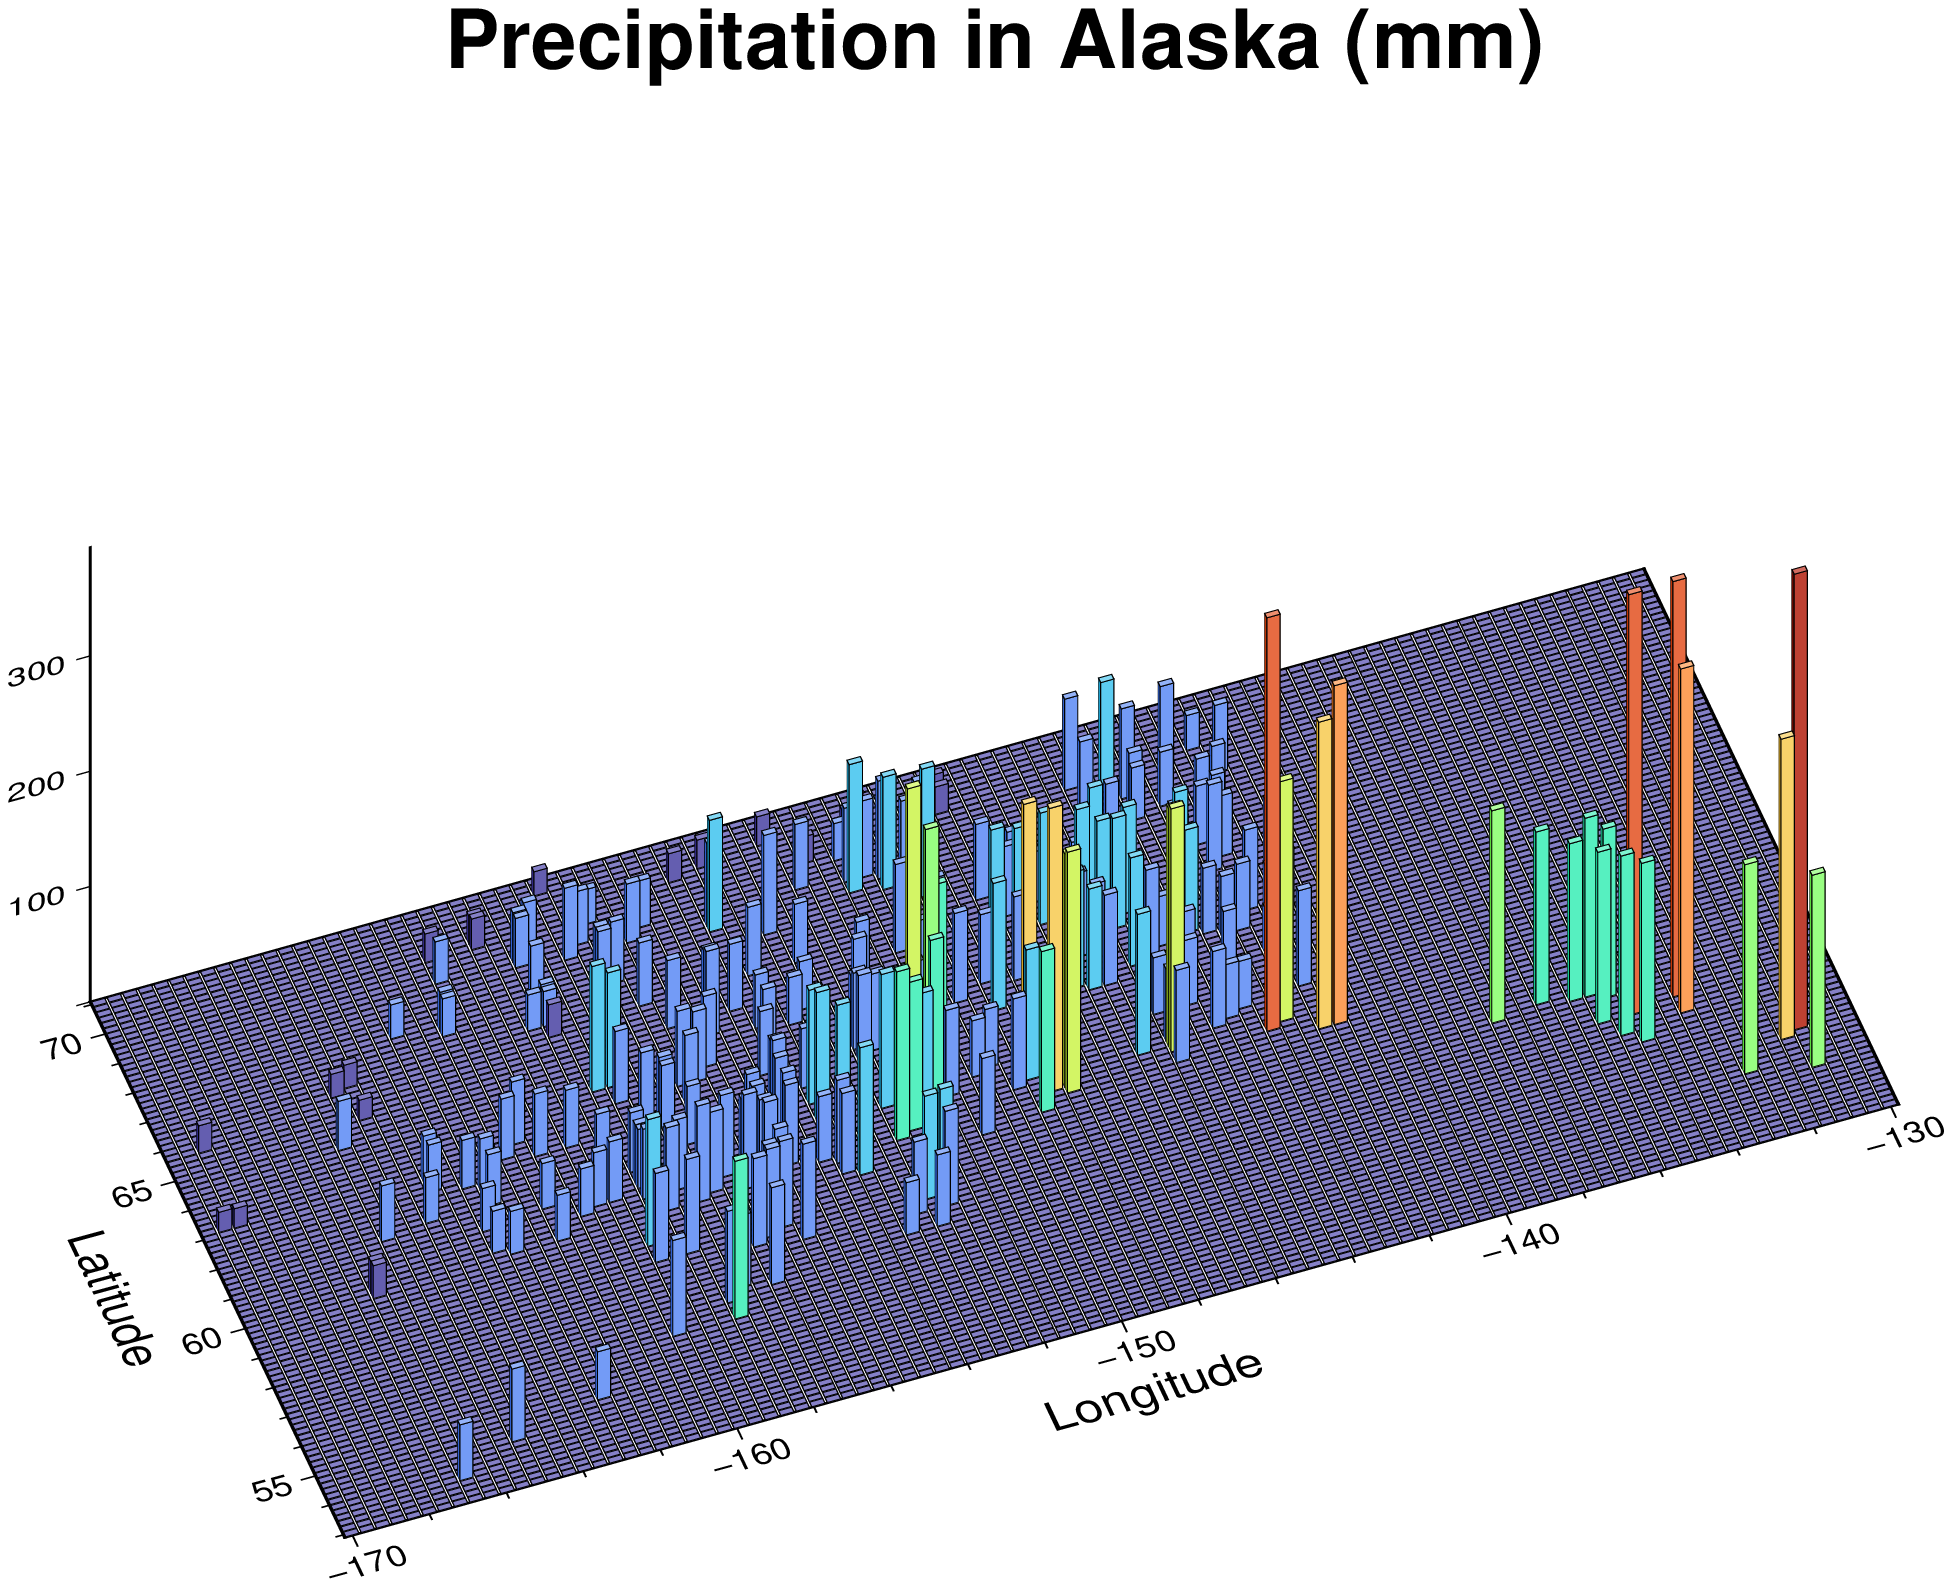

In [6]:
# Run me, don't change me! I create a 3D bar graph that
# displays the precipitation across the state of Alaska

grid = pixelate(subset, 100, 100)
cmap = GMT.grd2cpt(grid);  # Compute a colormap with the grid's data range

# Plotting function to make a 3D bar graph
GMT.bar3(grid, lw=:thinnest, color=cmap, fmt=:png, show=true, view=(200,50),
         xlabel="Longitude", ylabel="Latitude", title="Precipitation in Alaska (mm)")

We see that for most of the state of Alaska, not a lot of precipitation fell. However, near the south of Alaska where the state capitol Juneau resides, there was quite a bit of precipitation that fell relative to the rest of the state in July. And indeed it is quite beautiful there in the summer! 

__Reference__: https://www.alaska.org/photo-contest/anchorage-airport/entry-scott-johnson-juneau-alaska-this-past-summer-in-juneau-alaska-we-had-?e=entry-40278


![Juneau](https://www.alaska.org/assets/content/photo-contest/_large/FireweedAnchAirport-6378.jpg)

If you try plotting a higher percentage of measurement samples, you may feel that the 3D bar plot is already dense enough. However, note that each degree of difference in latitude/longitude is approximately 50-70 miles apart depending on where you are in the world (closer to the equator or pole etc.) Additionally, we wish to be able to create a model that allows us to estimate the precipitation level at any (longitude, latitude) pair at infinite resolution.

In the rest of the notebook, you will create a model that will be able to estimate the amount of precipitation that fell during the month of July anywhere in Alaska. To do this, you will perform a surface regression using the radial functions as your basis.

## Task 4: Build the Model

### Part A: Modify the Helper Functions

Just as in the previous notebook, we will need to build a pipeline for fitting our model. We can take our pipeline and helper functions from our previous notebook almost as is, except for the fact that now our data points (can also be referred to as the'x' values or lon/lat values) will be in $\mathbb{R}^2$. The value being measured, in this case the amount of precipitation, will remain in $\mathbb{R}$. This also means that our basis centers can no longer be determined by a single point. They will also be in $\mathbb{R}^2$. Our RBFs will now look like a hill where $x_c$ positions the hill somewhere in the xy plane, $a_i$ the coefficient determines how tall the hill is and $s$ determines how quickly values evaluated further and further from $x_c$ go to 0 or said another way the incline/gradient/steepness of the hill.


In the cells below, we have brought over 5 functions from the previous notebook:

* ```rbf```
* ```backwardsub```
* ```calc_phi_row```
* ```regressor_matrix```
* ```least_squres_qr```

Two of the functions ```calc_phi_row``` and ```regressor_matrix``` need to be modified to allow for passing in data that is now in $\mathbb{R}^2$ as we described above. Please identify and make the corresponding modifications.

In [7]:
# Run me, don't change me. I define the RBF.

# Radial basis function
rbf(x1, x2, s) = exp.(-norm(x1-x2)^2 / (2*s^2))

rbf (generic function with 1 method)

In [8]:
# Run me, don't change me. I will create a back substitution function that you can apply
# to systems of linear equations with an upper triangular "A" matrix, that we denote by U

"""
backwardsub(U, b)

It solves for x in an equation Ux = b, where U is upper triangular.
"""
function backwardsub(U, b)
    
    # Assert no entries in the diagonal of U
    # are 0 (or very close to 0)
    @assert minimum(abs.(diag(U))) > 1e-6
    
    n = length(b)
    x = Vector{Float64}(undef, n)

    x[n] = b[n] / U[n,n]
    for i in n-1:-1:1
        x[i]=(b[i] - (U[i,(i+1):n])' * x[(i+1):n]) ./ U[i,i]
    end
    
    return x    
end

backwardsub

In [9]:
# Modify me to work with xi in R2!
#
# I will create a function will be helpful in assembling our 
# Φ matrix assuming our model is a linear combination of RBFs

"""
function calc_phi_row(x, centers, s)

Returns a single row in the Φ matrix

Inputs:
    xᵢ      - the measurment xᵢ which are in R2
    centers - a Mx2 vector holding the centers of the determined RBFs
    s       - the shared kernel width (RBF width)
"""
function calc_phi_row(xᵢ, centers, s)
   
    phi_row_size = length(centers) + 1
    phi_row = Array{Float64, 1}(undef, phi_row_size)
    phi_row[1] = 1
    
    for i in 2:phi_row_size
        phi_row[i] = rbf(xᵢ, centers[i-1, :], s)
    end
    
    return phi_row
end

calc_phi_row

When performing calculations on large datasets, many functions may take a long time to execute. To measure how far along we are in the computation, we can make use of the facilities in the ProgressBar package. If you pass the range part of a for loop to a ProgressBar object, it will display a progress bar giving you an indication of how far along you are in executing the for loop. We added this change to the ```regressor matrix``` function below.

In [10]:
for i in ProgressBar(1:10000000)
   i = i  # Does nothing
end

0.0%┣                                     ┫ 0/10.0M [00:00<-138:-53:-51, -0s/it]
0.0%┣                                        ┫ 1/10.0M [00:00<Inf:Inf, InfGs/it]
5.0%┣█▉                                   ┫ 495.9k/10.0M [00:00<00:05, 2.1Mit/s]
9.4%┣███▌                                 ┫ 938.8k/10.0M [00:00<00:03, 2.9Mit/s]
14.6%┣█████▌                                ┫ 1.5M/10.0M [00:00<00:02, 3.7Mit/s]
19.2%┣███████▎                              ┫ 1.9M/10.0M [00:00<00:02, 4.3Mit/s]
22.1%┣████████▍                             ┫ 2.2M/10.0M [00:01<00:02, 4.2Mit/s]
27.3%┣██████████▍                           ┫ 2.7M/10.0M [00:01<00:02, 4.6Mit/s]
31.9%┣████████████▏                         ┫ 3.2M/10.0M [00:01<00:01, 4.9Mit/s]
35.3%┣█████████████▍                        ┫ 3.5M/10.0M [00:01<00:01, 5.1Mit/s]
40.4%┣███████████████▍                      ┫ 4.0M/10.0M [00:01<00:01, 5.3Mit/s]
45.2%┣█████████████████▏                    ┫ 4.5M/10.0M [00:01<00:01, 5.3Mit/s]
48.9%┣██████████████████▋   

In [28]:
# Modify me to work with data in R2!
#
# I will create a function that returns the regressor matrix 
# Φ based on our model using RBFs as basis functions

"""
function regressor_matrix()

Returns the regressor matrix Φ

Inputs:
    X       - a Nx2 vector holding the X value of all the measurements
    centers - a Mx2 vector holding the centers of the determined RBFs
    s       - the shared kernel width (RBF width)
"""
function regressor_matrix(X, centers, s)
    
    N = size(X,1)
    M = size(centers,1)
    phi = Array{Float64, 2}(undef, N, M+1)
    
    for i in ProgressBar(1:N)
        phi[i, :] = calc_phi_row(X[i,:], centers, s)'
    end
    
    return phi
end

regressor_matrix

In [12]:
# Run me, don't change me. 

"""
function least_squares_qr(A::Array{Float64,2},  b::Array{Float64,1})

Solves for x in Ax = b using the QR factorization. Returns x.
"""
function least_squares_qr(A::Array{Float64,2},  b::Array{Float64,1})
    F = qr(A)
    Q = Matrix(F.Q)
    R = Matrix(F.R)
    b_bar = Q' * b
    return backwardsub(R, b_bar)    
end

least_squares_qr

### Part B: Calculate the model weights

Now, you will setup the regression problem and use the functions implemented above to solve for the vector of weights ```a_star```. Note that even though our data has grown in dimension, we are still using the same model for fitting as in the end of notebook 1! As we saw when we plotted 1% of of the points, we could make out the shape of Alaska. Thus 1% of the data provides decent enough coverage of the state, so we will use those locations as our basis centers. In the next cell write the code necessary to solve for the coefficients of our model ```a_star```.

$$\hat{y} = a_1 + a_2 f(x; x_{c_1}, s) + a_3 f(x; x_{c_2}, s) + ... + a_{M+1} f(x; x_{c_M}, s)$$

In [26]:
data2= Matrix(data)
data2[1:5,:]

5×3 Matrix{Float64}:
 -153.498  67.21    59.9
 -159.866  65.6886  32.75
 -164.678  65.8171  16.48
 -159.159  70.5409  21.21
 -156.492  64.0326  59.61

In [50]:
# Modify me! I will calculate the coefficients of our model

# We will use a preset value for this project, but usually 
# you will need to play around with these values to find the 
# optimal fit. Do not modify these variables.
s = 1
percent = 1

# Do not modify the percent
centers = sample_rows(data, percent);

data2= Matrix(data)
# FILL in the pipeline here
stop = size(data2)
phi = regressor_matrix(data2[:,1], centers[:,1] ,s)
a_star = least_squares_qr(phi, data2[:,3])
# FILL in the pipeline here
#error is the minumum value (absolute value of U) is greater than 1e^-6
#Telling it to use 1:2 for indexing makes it step out of bounds
#Using one column results in an assertion error, which is a result of the combination of the number of radial basis functions, M and the width of aforementioned functions s.
#Which matrix is stepping out of bounds? is it maybe the function???

0.0%┣                                          ┫ 0/27.9k [00:00<-23:-13, -0s/it]
0.0%┣                                        ┫ 1/27.9k [00:00<Inf:Inf, InfGs/it]
9.4%┣███▋                                  ┫ 2.6k/27.9k [00:00<00:01, 18.9kit/s]
16.6%┣██████▏                              ┫ 4.6k/27.9k [00:00<00:01, 24.5kit/s]
21.9%┣████████                             ┫ 6.1k/27.9k [00:00<00:01, 25.4kit/s]
31.0%┣███████████▌                         ┫ 8.6k/27.9k [00:00<00:01, 29.8kit/s]
38.0%┣█████████████▊                      ┫ 10.6k/27.9k [00:00<00:01, 29.3kit/s]
44.1%┣████████████████                    ┫ 12.3k/27.9k [00:00<00:01, 29.8kit/s]
52.6%┣███████████████████                 ┫ 14.6k/27.9k [00:00<00:00, 31.6kit/s]
59.4%┣█████████████████████▍              ┫ 16.5k/27.9k [00:01<00:00, 30.9kit/s]
66.8%┣████████████████████████            ┫ 18.6k/27.9k [00:01<00:00, 30.3kit/s]
74.0%┣██████████████████████████▋         ┫ 20.6k/27.9k [00:01<00:00, 31.1kit/s]
79.3%┣██████████████████████

LoadError: AssertionError: minimum(abs.(diag(U))) > 1.0e-6

In [51]:
J = data2[:,1:2]
K = centers[:,1:2]
stop


(27861, 3)

In [52]:
# Autograder cell
### BEGIN HIDDEN TESTS
function p2_task4b_calc_phi_row(xᵢ, centers, s)
    
    phi_row_size = size(centers, 1) + 1
    phi_row = Array{Float64, 1}(undef, phi_row_size)
    phi_row[1] = 1
    
    for i in 2:phi_row_size
        phi_row[i] = rbf(xᵢ, centers[i-1, :], s)
    end
    
    return phi_row
end

function p2_task4b_regressor_matrix(X, centers, s)
    
    N = size(X, 1)
    M = size(centers, 1)
    phi = Array{Float64, 2}(undef, N, M+1)
    
    for i in 1:N
        phi[i, :] = p2_task4b_calc_phi_row(X[i, :], centers, s)'
    end
    
    return phi
end

p2_task4b_phi = p2_task4b_regressor_matrix(data[:,1:2], centers[:,1:2], s)
p2_task4b_a_star = least_squares_qr(p2_task4b_phi, data[:,3])
@assert isapprox(a_star, p2_task4b_a_star)
print("Passed Autograder Test!")
### END HIDDEN TESTS

LoadError: MethodError: no method matching -(::DataFrameRow{DataFrame, DataFrames.Index}, ::Vector{Float64})
[0mClosest candidates are:
[0m  -([91m::ChainRulesCore.AbstractThunk[39m, ::Any) at C:\Users\Dusks\.julia\packages\ChainRulesCore\RbX5a\src\tangent_types\thunks.jl:30
[0m  -([91m::StaticArrays.StaticArray[39m, ::AbstractArray) at C:\Users\Dusks\.julia\packages\StaticArrays\12k3X\src\linalg.jl:18
[0m  -([91m::SparseArrays.AbstractSparseMatrixCSC[39m, ::Array) at C:\Users\Dusks\AppData\Local\Programs\Julia-1.7.2\share\julia\stdlib\v1.7\SparseArrays\src\sparsematrix.jl:1776
[0m  ...

## Task 5. Plot the Surface

Now we estimate the precipitation that fell over the entire state of Alaska at discretized (longitude, latitude) pairs. Because, we did not get any precipitation measurements off of the coast of Alaska (measurements were only taken over land), we only estimate with our model if the (lon,lat) coordinate falls approximately on land. Your job is to fill in the code in the space provided (second cell below).

In [53]:
# Run me, don't change me. I divide up the state of Alaska into
# a series of squares that looks like a checkerboard / grid. In 
# the next cell we evaluate the precipitation for each square 
# in the grid.

# Latitude and longitude extremas of Alaska
lon_min = -178.0
lon_max = -130.0
lat_min = 51.0
lat_max = 72.0

# Number of squares we want on the x and y axis for plotting our 3D bar graph
n_xpixels = 200
n_ypixels = 200

lon_edges = collect(range(floor(lon_min), ceil(lon_max), length=n_xpixels)); # Values of our x-axis
lat_edges = collect(range(floor(lat_min), ceil(lat_max), length=n_ypixels)); # Values of our y-axis
gmt_grid = pixelate(data2, n_xpixels, n_ypixels); #drawing our 3D Bar Graph

The next cell is used to estimate the precipitation across Alaska. ```mat[i,j]``` should hold the precipitation that fell at lon/lat which are set at the beginning of the inner for loop each time. Use the model you just fit along with the available helper functions to estmiate the precipitation and set the value in ```mat[i,j]```.

In [68]:
# Modify me in the space below.

mat = zeros(n_ypixels, n_xpixels) #Initializing an empty 200 x 200 matrix
for i = 1:length(lat_edges) #iterate through our x values 
    for j = 1:length(lon_edges) #iterate through our y values 
        lon = lon_edges[j] #Lon is going to be our Longitude in the corresponding j index
        lat = lat_edges[i] #Lat is going to be our Latitude in the corresponding i index
        
        # Do not estimate if coordinate is not on land
        # We check this by seeing if there was any measured
        # precipitaton near that lon,lat pair in the original data set
        if gmt_grid.z[i,j] > 1e-6
            
            # FILL in the code here
            mat[i,j] = data2[j,3] #we need to get the corresponding precipitation data from at the corresponding longitude and latitude pair.
                                  #Look at what is at the given latitude, and use the corresponding precipitation amount (column 3)
            # FILL in the code here
            
        end
    end
end

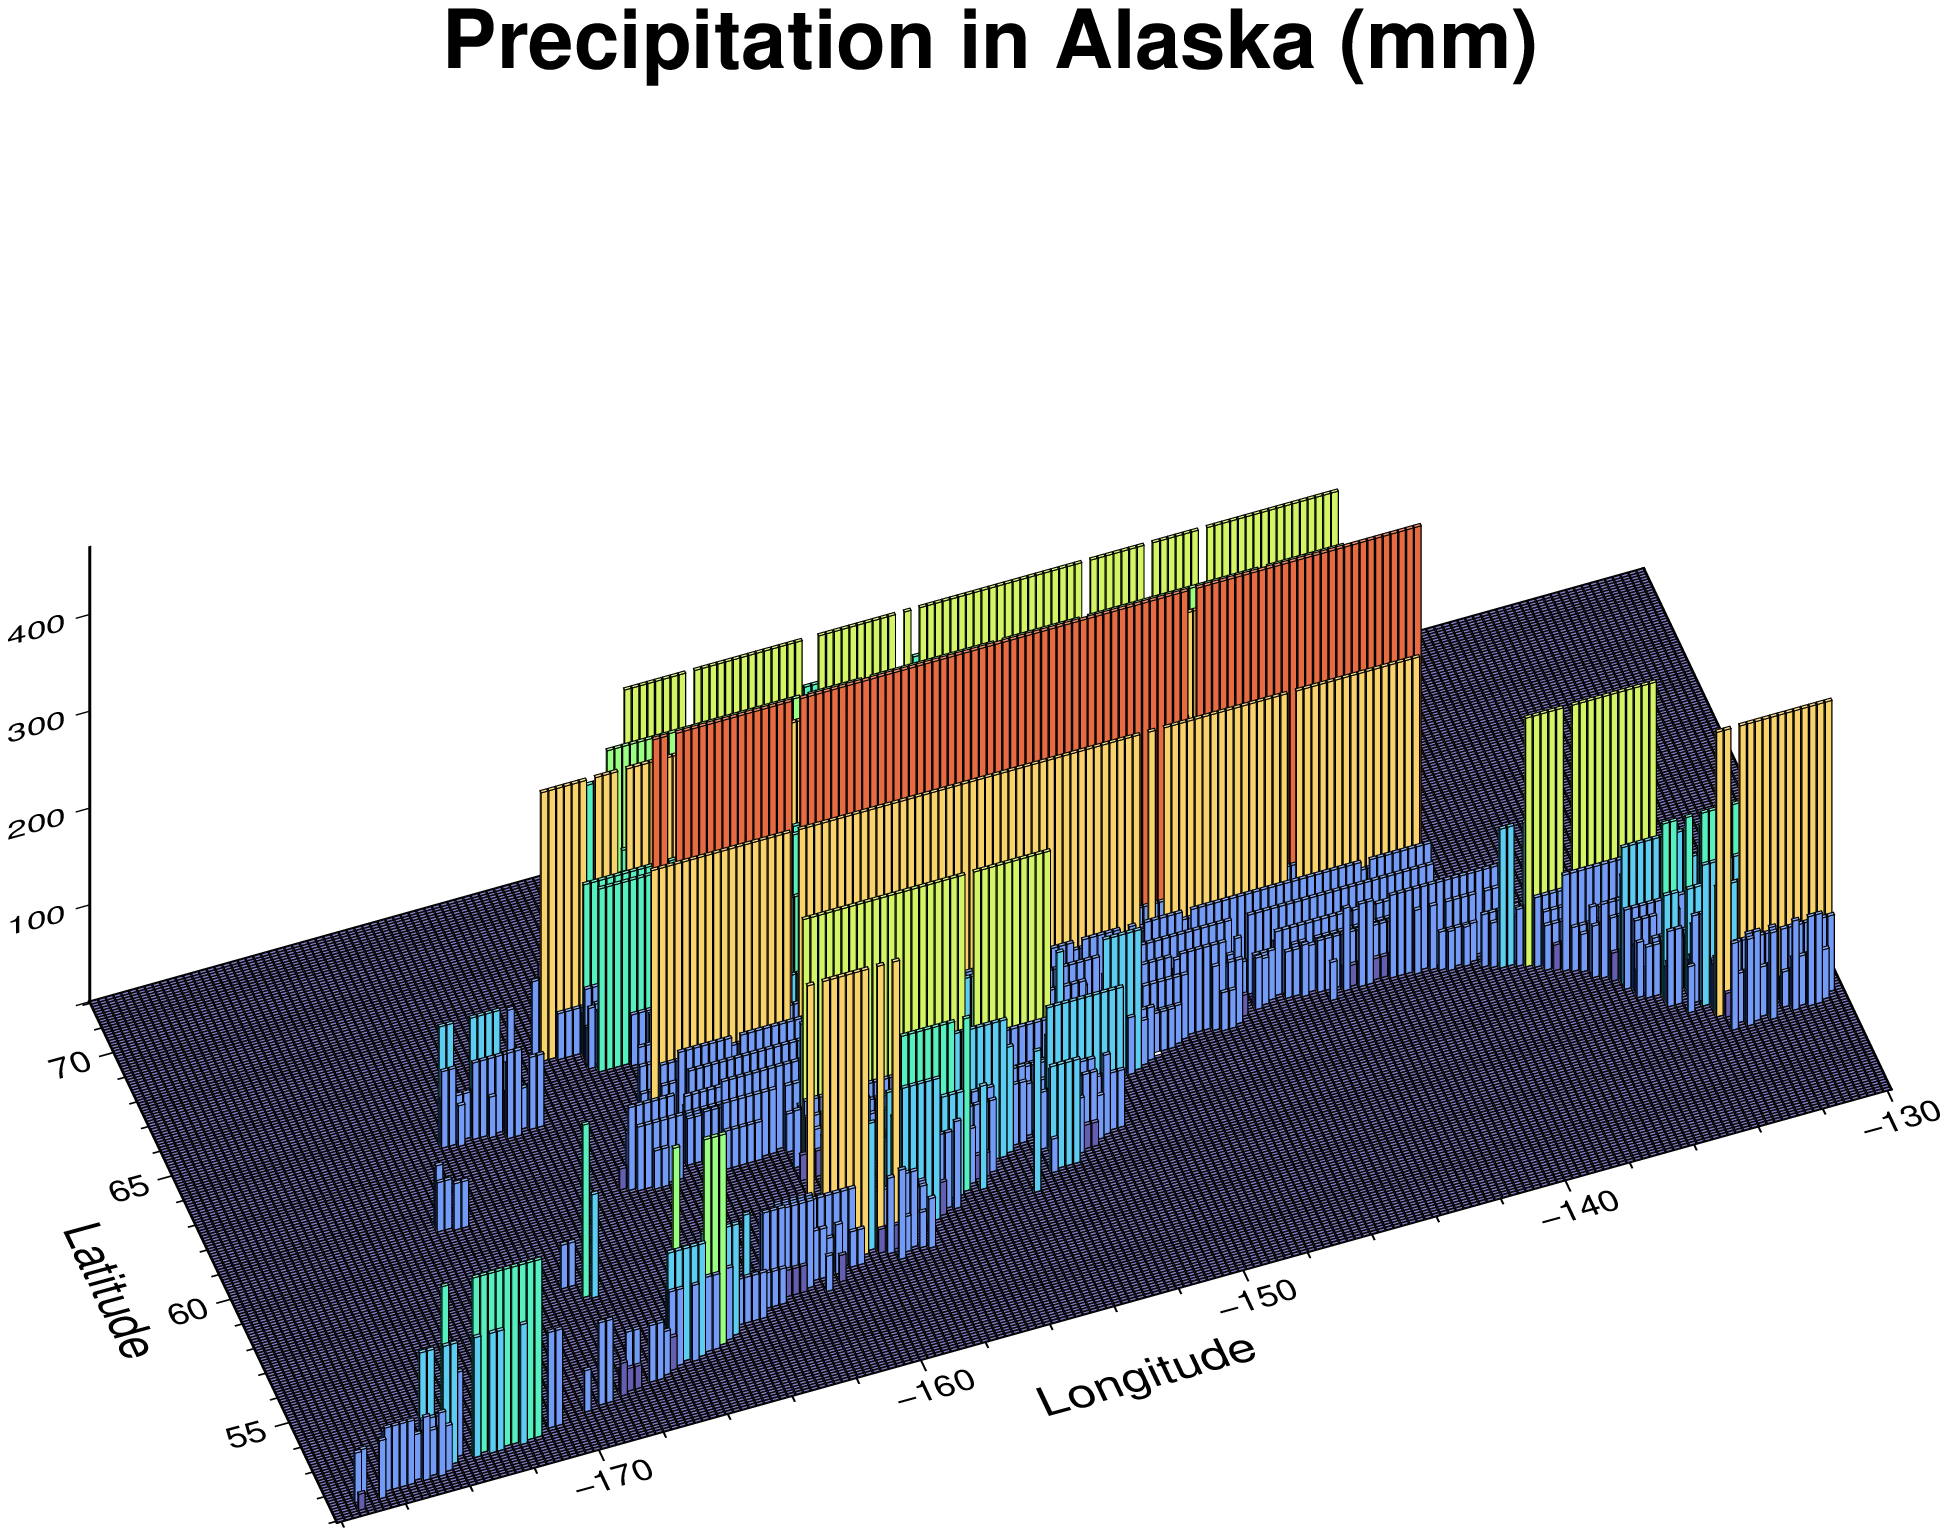

In [67]:
grid = GMT.mat2grid(mat, x=lon_edges, y=lat_edges)
cmap = GMT.grd2cpt(grid);  # Compute a colormap with the grid's data range

# Plotting function to make a 3D bar graph
GMT.bar3(grid, lw=:thinnest, color=cmap, fmt=:png, show=true, view=(200,50),
    xlabel="Longitude", ylabel="Latitude", title="Precipitation in Alaska (mm)")

Congratulations, you have fit a surface to the dataset! In your resulting contour graph, you should be able to notice 2-4 peaks which should appear in similar areas in your initial bar graph. With this model, you can now provide an estimate of the precipitation at any longitude and latitude pair in Alaska. As a quick example, let's test and see based on our model, how much precipitation in millimeters fell in Juneau, Alaska in July. We will use a longitude and latitude of (-134.410652, 58.301930) obtained from Google maps. You should see a value of 317.4 mm.

In [49]:
# Run me, don't change me. If you do not pass the test, take
# a look back at how you calculated a_star. Also, check to see
# that you did not change the value of s, or percent.

lat = 58.301930
lon = -134.410652

### BEGIN HIDDEN TESTS
rain_in_juneau = a_star' * calc_phi_row([lon, lat], centers[:,1:2], s)
@printf("In July 2020, a total of %.1f mm or rain fell in Juneau, Alaska.", rain_in_juneau)
@assert isapprox(rain_in_juneau, 317.4, atol=0.1)
### END HIDDEN TESTS

LoadError: UndefVarError: a_star not defined

How well does the estimation compare to real life? Take a look at this article: https://www.alaskasnewssource.com/2020/07/29/juneau-on-track-to-break-summer-rainfall-record/. With summer starting officially on June 20 in 2020, already 13 inches of rain feel by July 26. 317.4mm is about 12.5 inches, so our model does agree with reality. Pretty cool!